In [2]:
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell, GlobalAveragePooling2D, Input, Dropout, Attention, Bidirectional
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose, Conv3DTranspose
from sklearn.model_selection import train_test_split

In [1]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
file_inp = '/content/gdrive/MyDrive/ADL/set_5/train_normalized.npy'
file_tar = '/content/gdrive/MyDrive/ADL/set_5/test_normalized.npy'

train_input = np.load(file_inp)
train_target = np.load(file_tar)

#train_input= shuffle(train_input, random_state=0)

train_input.shape

(51098, 60, 16)

In [5]:
def normalize(x):
    b,a = -1,1
    x = a+(((x-np.min(x))*(b-a))/(np.max(x)-np.min(x)))
    return x

In [6]:
#x_train =train_input[:, :40,[0, 1,2,3,4,7,9,10,11,12]]
#y_train =train_input[:, 40:,[0, 1,2,3,4,7,9,10,11,12]]

#x_val = train_target[:, :40,[0, 1,2,3,4,7,9,10,11,12]]
#y_val =train_target[:, 40:,[0, 1,2,3,4,7,9,10,11,12]]


x_train =train_input[:, :40,:2]
y_train =train_input[:, 40:,:2]

x_val = train_target[:, :40,:2]
y_val =train_target[:, 40:,:2]

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((51098, 40, 2), (51098, 20, 2), (22785, 40, 2), (22785, 20, 2))

In [7]:
train_input.shape, train_target.shape

((51098, 60, 16), (22785, 60, 16))

In [8]:
model = tf.keras.Sequential()
model.add(LSTM(256, input_shape=(40, 2), return_sequences = True))
model.add(LSTM(128, return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(59, return_sequences=True))
model.add(LSTM(59, return_sequences=True))
model.add(LSTM(59))
#model.add(Dropout(rate=0.2))
model.add(RepeatVector(20))
model.add(LSTM(256, return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(59, return_sequences=True))
model.add(TimeDistributed(Dense(2)))
#model.compile(optimizer=tf.keras.optimizers.Nadam(
    #learning_rate=0.0005), loss='mse', metrics=['accuracy'])
model.compile(optimizer= 'nadam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 256)           265216    
                                                                 
 lstm_1 (LSTM)               (None, 40, 128)           197120    
                                                                 
 lstm_2 (LSTM)               (None, 40, 59)            44368     
                                                                 
 lstm_3 (LSTM)               (None, 40, 59)            28084     
                                                                 
 lstm_4 (LSTM)               (None, 59)                28084     
                                                                 
 repeat_vector (RepeatVector  (None, 20, 59)           0         
 )                                                               
                                                        

In [9]:
history = model.fit(x_train, y_train, epochs = 50, batch_size = 256, validation_data = (x_val, y_val))

Epoch 1/50
200/200 [==============================] - 26s 54ms/step - loss: 0.1674 - val_loss: 0.0856
Epoch 2/50
200/200 [==============================] - 8s 40ms/step - loss: 0.0563 - val_loss: 0.0472
Epoch 3/50
200/200 [==============================] - 8s 40ms/step - loss: 0.0416 - val_loss: 0.0442
Epoch 4/50
200/200 [==============================] - 8s 40ms/step - loss: 0.0364 - val_loss: 0.0330
Epoch 5/50
200/200 [==============================] - 8s 40ms/step - loss: 0.0320 - val_loss: 0.0330
Epoch 6/50
200/200 [==============================] - 8s 40ms/step - loss: 0.0310 - val_loss: 0.0311
Epoch 7/50
200/200 [==============================] - 8s 40ms/step - loss: 0.0283 - val_loss: 0.0305
Epoch 8/50
200/200 [==============================] - 8s 41ms/step - loss: 0.0285 - val_loss: 0.0330
Epoch 9/50
200/200 [==============================] - 8s 40ms/step - loss: 0.0264 - val_loss: 0.0293
Epoch 10/50
200/200 [==============================] - 8s 40ms/step - loss: 0.0263 - val_l

In [10]:
pred = model.predict(x_val)

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [11]:
x_train.shape, y_train.shape, pred.shape

((51098, 40, 2), (51098, 20, 2), (22785, 20, 2))

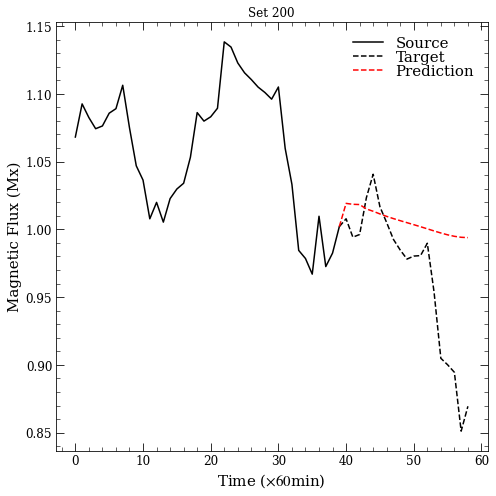

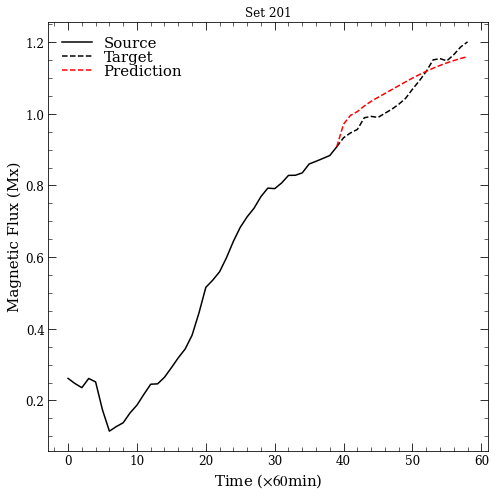

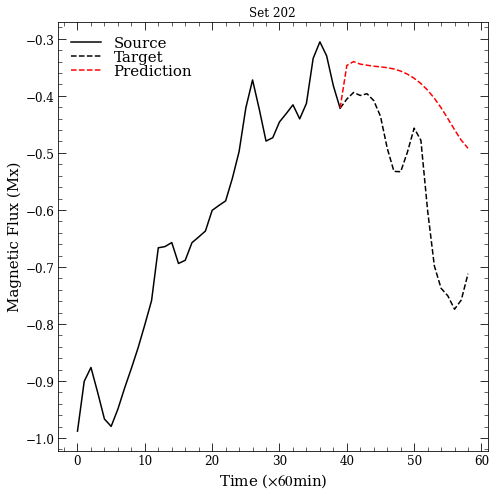

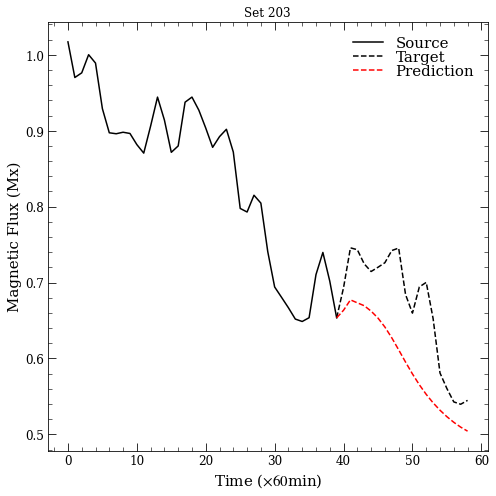

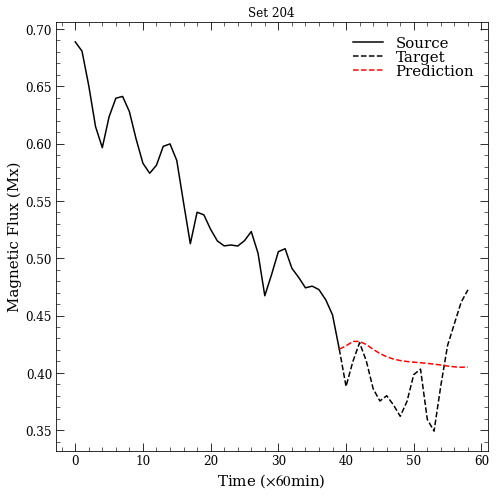

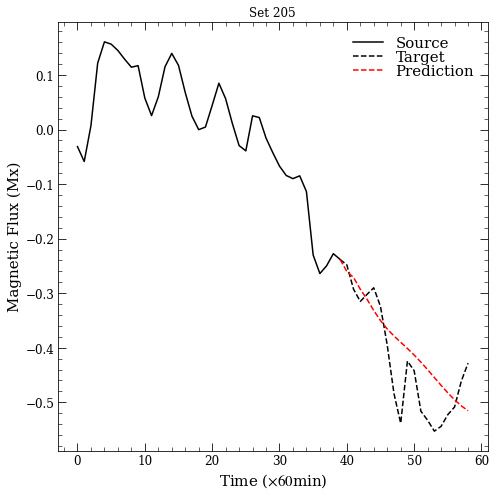

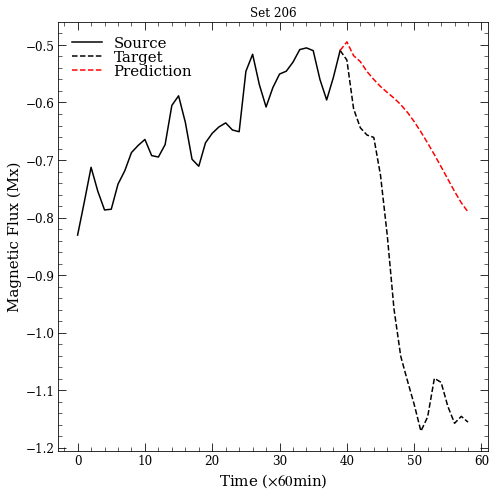

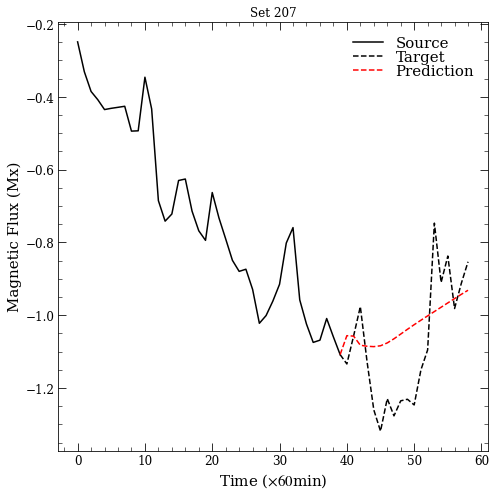

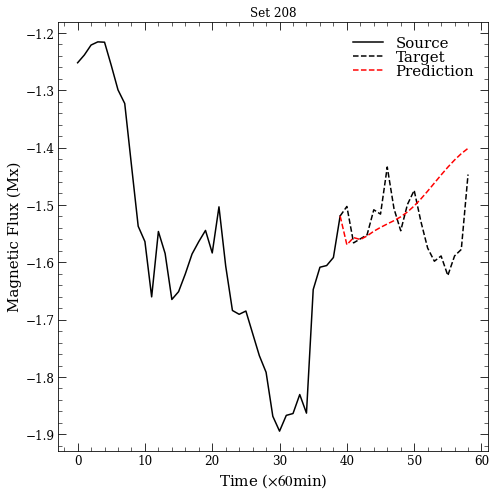

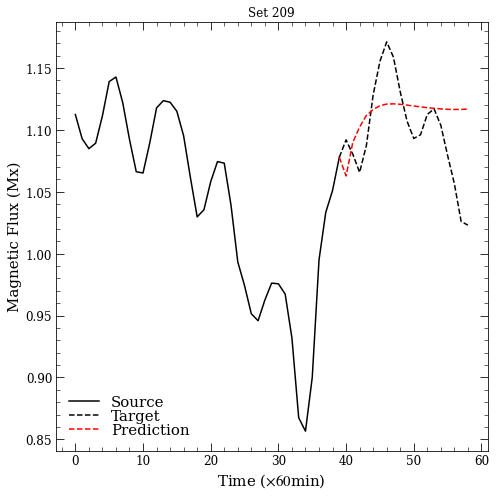

In [12]:
#plot a prediction

rc_font = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc_font)
plt.rcParams["legend.labelspacing"] = 0.001
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

#550-575
#650-675
x = np.arange(0, 60, 1)
for count in range(200,210):
  
  i = count #this is for the id, choose an id above 30000 if you want to a prediction on the validation set
  j = 0       #0 for mag flux plot, 1 for AR area plot
  save = False
  #y_true = list(train_input[i, :, j]) + list(train_target[i, :25, j])
  y_true = list(x_val[i,:,j]) 
  y_true_tar = list(x_val[i, :, j]) + list(y_val[i, :, j])
  y_pred = list(x_val[i, :, j]) + list(pred[i, :, j])
  fig, ax = plt.subplots(1, 1, figsize = (7, 7))
  ax.set_title('Set {}'.format(i))

  if j == 0:
    #ax.plot(x[:33], np.array(y_true) *std_flux + mu_flux, c = 'black', label = 'Source')
    #ax.plot(x[32:-1], np.array(y_true_tar) *std_flux + mu_flux, '--', c = 'black', label = 'Target' )
    #ax.plot(x[32:-1], np.array(y_pred[32:]) *std_flux + mu_flux, '--', c = 'red', label = 'Prediction')
    ax.plot(x[:40], np.array(y_true) , c = 'black', label = 'Source')
    ax.plot(x[39:-1], np.array(y_true_tar[39:-1]) , '--', c = 'black', label = 'Target' )
    ax.plot(x[39:-1], np.array(y_pred[39:-1]) , '--', c = 'red', label = 'Prediction')
    ax.set_ylabel('Magnetic Flux (Mx)', fontsize = 15)
    #plt.savefig('Pred_Flux_{}.pdf'.format(i))
  if j == 1:
    ax.plot(x[:33], np.array(y_true), c = 'black', label = 'Source' )
    ax.plot(x[32:-1], np.array(y_true_tar) , '--', c = 'black', label = 'Target' )
    ax.plot(x[32:-1], np.array(y_pred[32:]) , '--', c = 'red', label = 'Prediction')
    ax.set_ylabel('AR Area', fontsize = 15)
    #plt.savefig('Pred_Area_{}.pdf'.format(i))

  ax.legend(frameon = False, fontsize = 15)
  ax.set_xlabel(r'Time ($\times 60$min)', fontsize = 15)

  ax.minorticks_on()
  ax.tick_params(which = 'both', bottom = True, top = True, left = True, right = True)
  ax.tick_params(which = 'major', length = 8, direction = 'in', labelsize = 12)
  ax.tick_params(which = 'minor', length = 4, direction = 'in', labelsize = 12)
  if j == 0 & save:
    #plt.savefig('Pred_Flux_{}.pdf'.format(i))
    pass
  else:
    #plt.savefig('Pred_Area_{}.pdf'.format(i))
    pass

  #plt.show()
  plt.tight_layout()
  plt.savefig('/content/gdrive/MyDrive/ADL/results_10_features/'+str(i)+'.png', dpi = 200, format = 'png', bbox_inches = 'tight')